---
<div align="center">

# Lung Cancer Classification
</div>

---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import radiomics
from radiomics import (featureextractor)
import customPylidc as pl
from customPylidc.utils import (volume_viewer)
from FeatureExtraction import (extractPyradiomicsFeatures)

---
## Data Exploration and Extraction
---

> ADD A CONTEXT FOR THE DATA [EG: A PATIENT CAN CONTAIN MULTIPLE NODULES AS WELL AS MULTIPLE ANNOTATIONS FOR THE SAME NODULE]


---
### Dataset Dimensions (?)
---

First of all, let's start by analysing the dataset dimensions in terms of the amount of patients, scans and annotations.

In [4]:
# Checking the amount of patients available
print(f"There are {np.unique(np.array([scan.patient_id for scan in pl.query(pl.Scan).all()])).size} Total Patients")

There are 1010 Total Patients


In [5]:
# Checking the amount of scans available
print(f"There are {len(pl.query(pl.Scan).all())} Scans available")

There are 1018 Scans available


In [6]:
# Checking the amount of Annotations available
print(f"There are {len(pl.query(pl.Annotation).all())} Annotation available")

There are 6859 Annotation available


---
### Patient Nodules Visualization
---

Let's select the first patient and visualize how his nodules data look like.

In [7]:
# Choose a patient ID
pid = 'LIDC-IDRI-0001'

# Fetch the patient's scan
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

# Get the Patient Nodules Annotations
patientNodules = scan.cluster_annotations()
print(f"The Patient {pid}'s Scan has {len(patientNodules)} Nodule(s)")

# Get the Scan's first annotation
ann = scan.annotations[0]

The Patient LIDC-IDRI-0001's Scan has 1 Nodule(s)


Loading dicom files ... This may take a moment.


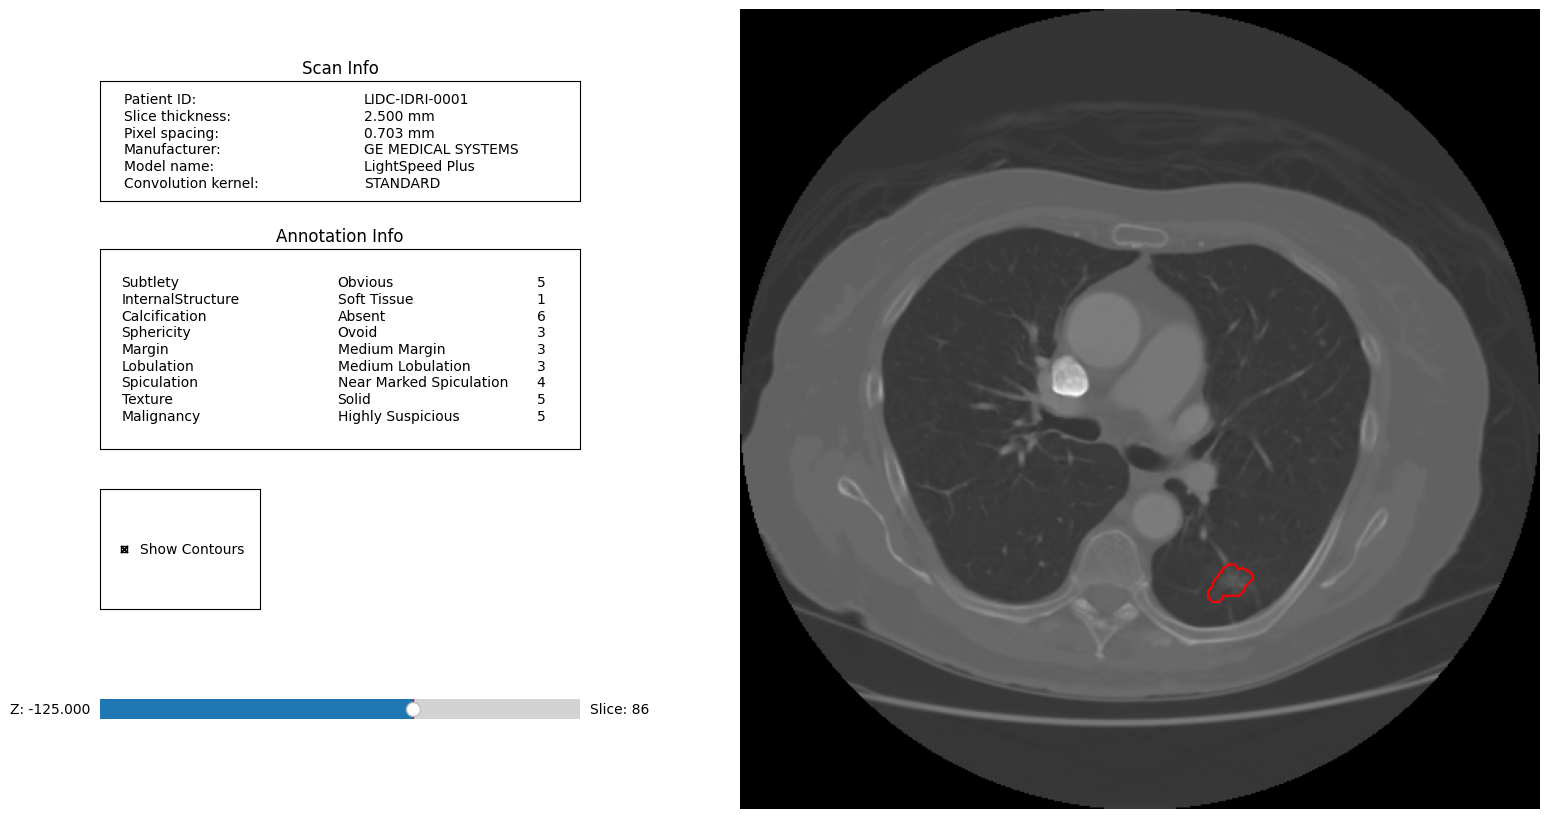

In [8]:
# Visualize the CT Scan
ann.visualize_in_scan()

Loading dicom files ... This may take a moment.


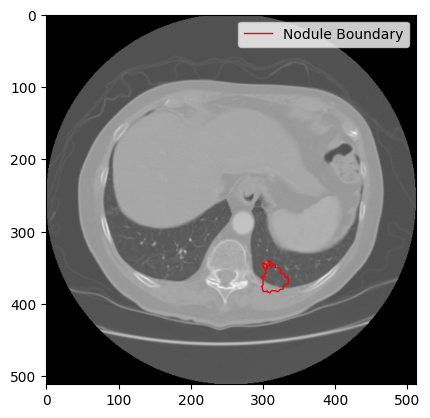

In [9]:
vol = ann.scan.to_volume()
con = ann.contours[3]

k = con.image_k_position
ii,jj = ann.contours[3].to_matrix(include_k=False).T

plt.imshow(vol[:,:,46], cmap=plt.cm.gray)
plt.plot(jj, ii, '-r', lw=1, label="Nodule Boundary")
plt.legend()
plt.show()

Loading dicom files ... This may take a moment.


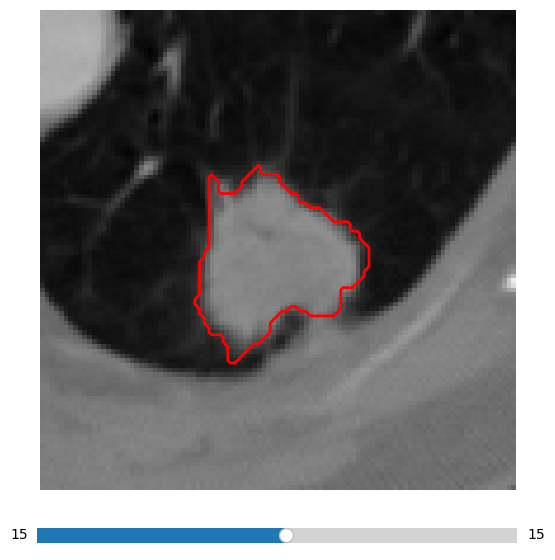

In [10]:
# Get the volume of the nodule
vol = ann.scan.to_volume()

# Define a padding
padding = 70.0

# Fetch the mask and bounding box
mask = ann.boolean_mask(pad=padding)
bbox = ann.bbox(pad=padding)

# Plot the Nodule
volume_viewer(vol[bbox], mask, ls='-', lw=2, c='r')

Loading dicom files ... This may take a moment.


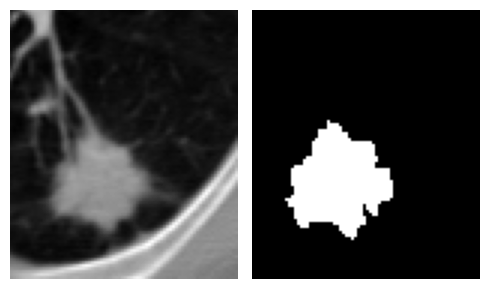

In [11]:
vol = ann.scan.to_volume()

padding = [(30,10), (10,25), (0,0)]

mask = ann.boolean_mask(pad=padding)
bbox = ann.bbox(pad=padding)

fig,ax = plt.subplots(1,2,figsize=(5,3))

ax[0].imshow(vol[bbox][:,:,2], cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].imshow(mask[:,:,2], cmap=plt.cm.gray)
ax[1].axis('off')

plt.tight_layout()
#plt.savefig("../images/mask_bbox.png", bbox_inches="tight")
plt.show()

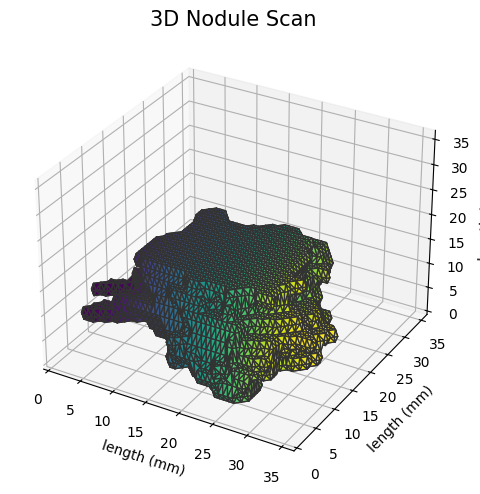

In [12]:
# Plot the Nodule 3D Scan
ann.visualize_in_3d()

---
## PyLIDC Feature Extraction
---

> The package contains the semantical features

After reviewing and reconsidering the Nodule Attributes in the [Pylidc package documentation](https://pylidc.github.io/) (as also summarized in the [README.md](./customPylidc/README.md) file within our customPylidc package), we selected those which we believe could contribute most significantly to predicting nodule malignancy. Consequently, we created a simple framework for dataset creation, which will be populated by querying the data from the aforementioned package.

In [13]:
# Define the initial structure of the Dataframe
df_pylidc = pd.DataFrame(columns=['patient_id',          # Patient Identification Number [Form “LIDC-IDRI-dddd” where dddd is a string of integers]
                                  'annotation_id',       # Annotation Identification Number
                                  'scan_id',             # Scan Identification Number
                                  'slice_thickness',     # DICOM attribute (0018,0050)
                                  'pixel_spacing',       # Dicom attribute (0028,0030)
                                  'subtlety',            # Difficulty of detection
                                  'internalStructure',   # Internal composition of the nodule
                                  'calcification',       # Pattern of calcification
                                  'sphericity',          # Three-dimensional shape of the nodule 
                                  'margin',              # How well-defined the nodule margin is
                                  'lobulation',          # Degree of lobulation
                                  'spiculation',         # Extent of spiculation present
                                  'texture',             # Radiographic solidity - internal texture
                                  'diameter',            # Maximal diameter
                                  'surface_area',        # Estimated surface area
                                  'volume',              # Estimated 3D volume of the annotated nodule
                                  'malignancy',          # likelihood of malignancy -> Target [What we want to predict]
                                 ])

# Removing empty row
df_pylidc = df_pylidc.dropna(axis=1, how='all')

In [14]:
# Define a name for the file to store the pylidc features
pylidcFeaturesFilename = 'pylidc_features.csv'

# If the results have yet to be extracted (The .csv file with the pylidc features does not exist)
if not os.path.exists(f'./{pylidcFeaturesFilename}'):

    # Fetch all the Annotations Available
    ann = pl.query(pl.Annotation).all()
    
    for i in range(len(ann)):
        # Initialize a dictionary with the df's attributes / columns and empty strings
        att  = dict((col, "") for col in df_pylidc.columns)
    
        # Saving the personal identifiable identification [PII]
        att['patient_id'] = ann[i].scan.patient_id
        att['annotation_id'] = ann[i].id  
        att['scan_id'] = ann[i].scan.id
        
        # -> Fetch and Save the Nodule's characteristics [Features]

        # Get and Save the slice thickness
        st = pl.query(pl.Scan.slice_thickness).filter(pl.Scan.id == att['scan_id'])
        s = str(st[0])
        att['slice_thickness'] = float(s[1:4])

        # Get and Save the pixel spacing
        ps = pl.query(pl.Scan.pixel_spacing).filter(pl.Scan.id == att['scan_id'])
        p = str(ps[0])
        att['pixel_spacing'] = float(p[1:5])

        # Saving remaining values
        att['subtlety'] = ann[i].subtlety
        att['internalStructure'] = ann[i].internalStructure 
        att['calcification'] = ann[i].calcification 
        att['sphericity'] = ann[i].sphericity
        att['margin'] = ann[i].margin  
        att['lobulation'] = ann[i].lobulation
        att['spiculation'] = ann[i].spiculation 
        att['texture'] = ann[i].texture
        att['diameter'] = ann[i].diameter
        att['surface_area'] = ann[i].surface_area
        att['volume'] = ann[i].volume
    
        # Target
        att['malignancy'] = ann[i].malignancy  

        # Convert the new row into a Dataframe and add it to the previous one
        df_att = pd.DataFrame.from_dict([att])
        df_pylidc = pd.concat([df_pylidc, df_att], ignore_index=True)
    
    # Sort the dataframe based on the patient ID feature
    df_pylidc = df_pylidc.sort_values(by=['patient_id'], ascending=[True])
    
    # Save the results into a .csv file
    df_pylidc.to_csv(pylidcFeaturesFilename, sep=',', index=False)

Since each annotation represents the characteristics of a patient's nodule, we have decided to refactor the annotation column in order to contain the patient id followed by the a nodule identifier number. Therefore, we added a new column nodule_id and removed both the annotations and scans columns.

In [15]:
# Define a name for the new version of the dataset
pylidcRefactoredFeaturesFilename = 'refactored_pylidc_features.csv'

# If the results have yet to be refactored
if not os.path.exists(f'./{pylidcRefactoredFeaturesFilename}'):
    # Read the previous dataframe
    df_pylidc = pd.read_csv(f'./{pylidcFeaturesFilename}')
    
    # Get the Id of the first patient in the dataset
    currentPatient = df_pylidc['patient_id'][0]
    
    # Variable to keep track of the nodule ID of the current patient
    noduleId = 0
    
    # List to store the new format for the nodule_id feature
    newColumnData = []
    
    # Iterate through the dataset
    for index, row in df_pylidc.iterrows():
        # Update the nodule id count if the current entry has the same patient as the previous one
        if row['patient_id'] == currentPatient:
            noduleId += 1
        else:
            # Update current patient and his current nodule Id
            currentPatient = row['patient_id']
            noduleId = 1
    
        # Append a new nodule_id value
        newColumnData.append(f"{row['patient_id']}-{noduleId}")
    
    # Insert the nodule identification
    df_pylidc.insert(0, "nodule_id", newColumnData, True)
    
    # Drop Unnecessary columns
    df_pylidc = df_pylidc.drop(['annotation_id', 'scan_id'], axis=1)
    
    # Save new dataset into a .csv file
    df_pylidc.to_csv(f'./{pylidcRefactoredFeaturesFilename}', sep=',', index=False)

In [16]:
# Inspect the new dataset
df_pylidc = pd.read_csv(f'./{pylidcRefactoredFeaturesFilename}')
df_pylidc.head()

,nodule_id,patient_id,slice_thickness,pixel_spacing,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,diameter,surface_area,volume,malignancy
0,LIDC-IDRI-0001-1,LIDC-IDRI-0001,2.5,0.70,5,1,6,3,3,3,4,5,32.205888,2801.428431,7869.369507,5
1,LIDC-IDRI-0001-2,LIDC-IDRI-0001,2.5,0.70,5,1,6,4,4,5,5,5,33.188692,2198.454852,6146.438599,5
2,LIDC-IDRI-0001-3,LIDC-IDRI-0001,2.5,0.70,5,1,6,3,2,3,3,5,31.959332,2392.704188,6594.474792,5
3,LIDC-IDRI-0001-4,LIDC-IDRI-0001,2.5,0.70,5,1,6,5,4,1,5,4,33.669337,2573.278820,7348.411560,4
4,LIDC-IDRI-0002-1,LIDC-IDRI-0002,1.2,0.68,2,1,6,5,1,1,1,1,30.023172,2880.758652,6576.900681,5


---
## Pyradiomics Feature Extraction
---

> Describe the extraction setup and what we aim to gain from it. What was used (Packages, other resources, ....)
> Perform the extraction with the images and merge the results with the previous dataset
> Clean the Data and save it

In [17]:
# Variable to determine if we perform feature extration using the pyradiomics package
extractPyradiomicsFeatures = False

# Perform Pyradiomics Feature Extraction
if extractPyradiomicsFeatures:
    files_path = 'c:\\Insert\\Global\\Path\\To\\LIDC-IDRI'
    extractPyradiomicsFeatures(Lidc_IdrFilesPath=files_path,
                               pyradiomicsDcmScriptPath='./pyradiomics-dcm.py',
                               pyradiomicsParamsFilePath='./Pyradiomics_Params.yaml',
                               pyradiomicsFeatureDictFilePath='./featuresDict.tsv',
                               startPatient=0,
                               outputDirectoryPath='./OutputSR',
                               tempDirectoryPath='./TempDir')

In [18]:
# Load the Dataset
df_pyradiomics = pd.read_csv('pyradiomics_features.csv', index_col=False)
df_pyradiomics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4688 entries, 0 to 4687
Columns: 1599 entries, Nodule_Id to logarithm_ngtdm_Strength
dtypes: float64(1565), int64(4), object(30)
memory usage: 57.2+ MB


In [19]:
# Check the dataframe dimensions
rows, cols = df_pyradiomics.shape
print(f"The pyradiomics feature dataset contains {rows} rows and {cols} cols")

The pyradiomics feature dataset contains 4688 rows and 1599 cols


In [20]:
# Inspect the first rows from the dataset
df_pyradiomics.head()

,Nodule_Id,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,...,logarithm_gldm_LargeDependenceLowGrayLevelEmphasis,logarithm_gldm_LowGrayLevelEmphasis,logarithm_gldm_SmallDependenceEmphasis,logarithm_gldm_SmallDependenceHighGrayLevelEmphasis,logarithm_gldm_SmallDependenceLowGrayLevelEmphasis,logarithm_ngtdm_Busyness,logarithm_ngtdm_Coarseness,logarithm_ngtdm_Complexity,logarithm_ngtdm_Contrast,logarithm_ngtdm_Strength
0,LIDC-IDRI-0001-1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.315204,0.038768,0.437417,662.328267,0.014300,0.143802,0.002087,36576.623708,6.768040,14.090091
1,LIDC-IDRI-0001-2,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.030970,0.009428,0.439498,682.658274,0.006310,0.099596,0.002513,31985.177011,5.824263,14.843045
2,LIDC-IDRI-0001-3,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.051793,0.013446,0.478543,777.359773,0.007703,0.117973,0.002163,39403.439571,6.843639,14.682214
3,LIDC-IDRI-0001-4,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.103967,0.018713,0.463454,710.169563,0.008608,0.134292,0.002153,35828.160714,7.225162,14.078258
4,LIDC-IDRI-0002-1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,75.851878,0.455616,0.104524,126.985909,0.012662,0.792276,0.007417,3154.963087,0.988412,55.765308


In [21]:
# Clean the Dataframe [NEEDS CHECKING]
df_pyradiomics = pd.read_csv('pyradiomics_features.csv', index_col=False)
df_pyradiomics.iloc[:, 143:] = df_pyradiomics.iloc[:, 143:].apply(lambda x: x.shift(273) if x.isna().any() else x, axis=1)
df_pyradiomics = df_pyradiomics.sort_values(df_pyradiomics.columns[0])
df_pyradiomics = df_pyradiomics.reset_index(drop=True)
df_pyradiomics.head()

,Nodule_Id,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,...,logarithm_gldm_LargeDependenceLowGrayLevelEmphasis,logarithm_gldm_LowGrayLevelEmphasis,logarithm_gldm_SmallDependenceEmphasis,logarithm_gldm_SmallDependenceHighGrayLevelEmphasis,logarithm_gldm_SmallDependenceLowGrayLevelEmphasis,logarithm_ngtdm_Busyness,logarithm_ngtdm_Coarseness,logarithm_ngtdm_Complexity,logarithm_ngtdm_Contrast,logarithm_ngtdm_Strength
0,LIDC-IDRI-0001-1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.315204,0.038768,0.437417,662.328267,0.014300,0.143802,0.002087,36576.623708,6.768040,14.090091
1,LIDC-IDRI-0001-2,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.030970,0.009428,0.439498,682.658274,0.006310,0.099596,0.002513,31985.177011,5.824263,14.843045
2,LIDC-IDRI-0001-3,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.051793,0.013446,0.478543,777.359773,0.007703,0.117973,0.002163,39403.439571,6.843639,14.682214
3,LIDC-IDRI-0001-4,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,0.103967,0.018713,0.463454,710.169563,0.008608,0.134292,0.002153,35828.160714,7.225162,14.078258
4,LIDC-IDRI-0002-1,v3.1.0,1.24.3,2.4.0,1.6.0,3.9.0,"{'minimumROIDimensions': 2, 'minimumROISize': ...","{'Original': {}, 'LoG': {'sigma': [1.0, 2.0, 3...",536a24a547656a8d43436937029df0d651b44259,3D,...,75.851878,0.455616,0.104524,126.985909,0.012662,0.792276,0.007417,3154.963087,0.988412,55.765308


---

## TODO:
- Identify and Describe the Problem
- Identify the business, its goals and possible constraints for the solution and the used pipeline
- Weight the 2D vs 3D image processing paradigm and choose which one to use and why

<br/>

- Perform Exploratory Data Analysis [Class Imbalance, Check type of problem - if we can switch from multi-class to binary classification, maybe perform synthetic sampling or data prunning, If there is a lot of data maybe consider a PCA to reduce processing costs]
- Select Algorithms and the reasons behind the choice
- Split the data based on a K-Fold Cross Validation Stratigy
- Perform Grid Search for parameter tunning on each one of the algorithms
- Train the model with the best hyperparameters found and evaluate the performance based on multiple metrics [balanced accuracy, f1-score, ...]
- Perform a statistical evaluation on the model's performance
- Does it achieve the business goals and at what costs?
- Ethical Considerations and identify possible privacy breaches (even though the data is anonimized)
- YouTube Presentation Video
- Bibliographic References